In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [2]:
#read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
vocab_size

27

In [5]:
#build the dataset
block_size = 8 #context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words[:]:
        #print(f'Word: {w}')
        context = [0] * block_size 
        ##print(''.join(str(context)))
        for ch in w + '.':
            ix = stoi[ch]
            #print(f'ix: {ix}')
            X.append(context)
            Y.append(ix)
            ##print('Appended context into X and ix into Y')
            context = context[1:] + [ix] #crop and append
            #print(''.join(str(context)))

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    #print(X)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [23]:
#Repeated but torchified i.e. resembles the existing pytorch library

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d: #See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html and https://www.youtube.com/watch?v=4gal2zIjm3M

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backpropagation, affine is set to True here)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self, x):
        if self.training:
            #Bug where we assume x is 2d, but with WaveNet + Flatten, x is actually 3d
            #Therefore account for the 3d case where we still want to calculate the mean and variance across each input in the batch
            #This results in n_
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) #batch mean
            xvar = x.var(dim, keepdim=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:
    #num_embeddings being the number of characters being embedded into embedding_dim dimension
    #e.g. 27 characters (num_embeddings) into 10 dimensions
    def __init__ (self, num_embeddings, embedding_dim): 
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

#Different from the pytorch API
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n) ##// being the integer division operator
        #If concatenation of letters gets to the point that we have all the characters in a single layer, 
        #squeeze out the 1st dimension (counting from zero) so that we only get (B, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

#PyTorch container
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        #get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()] 

In [8]:
torch.manual_seed(42) #seed rng for reproducibility

In [27]:
n_embd = 10 #the dimensionality of the character-embedding vectors
n_hidden = 68 #the number of neurons in the hidden layer of the MLP

# layers = [
#     Embedding(vocab_size, n_embd),
#     Flatten(),
#     Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(           n_hidden, vocab_size),
# ]

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
])


# with torch.no_grad():
#     #last layer: make less confident
#     layers[-1].weight *= 0.1

#parameter initialisation
#parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) #number of parameters total
    
for p in parameters:
    p.requires_grad = True


22397


In [17]:
#Using a batch of 4 examples, we want e (Shape of (4, 8, 10))to be (4, 4, 20) where consecutive 10-d vectors get concatenatec
e = torch.randn(4, 8, 10)
print(torch.cat([e[:, ::2, :], e[:, 1::2, :]],dim=2).shape)

torch.Size([4, 4, 20])


In [40]:
#Quick batch of 4 examples
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)

torch.Size([4, 8])


In [25]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [29]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [28]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None #Removes current grad so that it doesn't get added onto the grad that's calculated in the next line
    loss.backward()

    #update: SGD
    lr = 0.1 if i < 150000 else 0.01 #step rate learning decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print (f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.5779


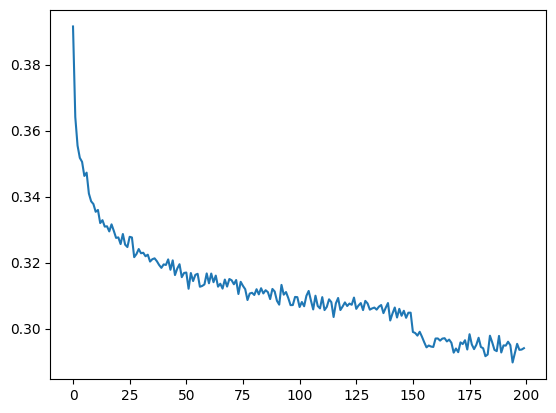

In [13]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [14]:
#put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [15]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9424288272857666
val 2.0275375843048096


In [16]:
#sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size #initialise with all ellipsis
    while True:
        #forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.', token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) #decode and print the generated word

lansan.
dylina.
jenilia.
kailon.
benon.
chalee.
coulan.
rivay.
jaleed.
zeyelle.
isaby.
synne.
elza.
ziake.
annelis.
ennasa.
damaari.
jermak.
allisheon.
darleigh.


In [60]:
#MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),  generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5) #Kaiming init: Gain for tanh / sqrt of fan-in number of neurons
#final product, bias is excluded because it cancels out with the mean in batch normalisation
#batch normalisation also has its own bias i.e. bnbias
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),  generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden)) #Initialising at ones and zeroes allows for neurons to be unit-Gaussian at initialisation
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [12]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    print(f'ix: {ix}')
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
    print(f'Xb: {Xb}')

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    print(f'Shape of emb: {emb.shape}')
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    print(f'Shape of embcat: {embcat.shape}')
    #Linear layer
    hpreact = embcat @ W1 #+ b1 #hidden layer pre-activation
    print(f'Shape of linear layer hpreact: {hpreact.shape}')

    #Batchnorm layer
    #----------------------------------------------------------------
    # calculate the mean and stddev for current batch
    # also used for estimating the mean and stddev of the whole training set
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    #normalise the hidden layer to make it Gaussian and then scale and shift by adding a gain and bias
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    print(f'Shape of batchnorm layer hpreact: {hpreact.shape}')
    print(f'Shape of batchnorm layer bnmeani: {bnmeani.shape}')
    print(f'Shape of batchnorm layer bnstdi: {bnstdi.shape}')

    #running mean and std.dev aren't part of the forward or backward pass hence no_grad()
    #the with keyword essentially creates a no_grad block that frees resources by itself at the end
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #----------------------------------------------------------------

    #Non-linearity
    h = torch.tanh(hpreact) #hidden layer
    print(f'Shape of tanh layer h: {h.shape}')
    logits = h @ W2 + b2 #output layer
    print(f'Shape of output layer logits: {logits.shape}')
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0: #print every once and a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

ix: tensor([ 38074, 172070,  10936, 104037, 126183,  49014,  61127, 135541,  76747,
         52439,  31633,  75534,   6719, 174816,  87187, 143292,  13944,  45228,
         95872,  15451,  22012, 177970, 100120, 164054, 160647, 149691,  39451,
        146577,  98593,  26894,   2723,  74300])
Xb: tensor([[ 1, 12, 25],
        [ 0,  0,  3],
        [ 0,  0,  0],
        [18,  9,  1],
        [18, 15, 19],
        [12,  5, 14],
        [11,  1, 19],
        [18,  9,  1],
        [ 0,  0,  0],
        [12,  1, 25],
        [ 0,  0,  3],
        [ 3,  9,  1],
        [13,  1, 24],
        [ 0,  1, 14],
        [ 4,  4,  8],
        [26,  1,  2],
        [14, 14,  1],
        [14,  1, 12],
        [ 1, 14,  4],
        [13,  1,  8],
        [12,  9,  3],
        [ 1, 14,  9],
        [ 0,  0,  0],
        [ 0,  0, 13],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0, 16],
        [ 8,  1, 26],
        [ 5, 25, 26],
        [22,  1, 25],
        [ 0,  0,  0]]

In [11]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

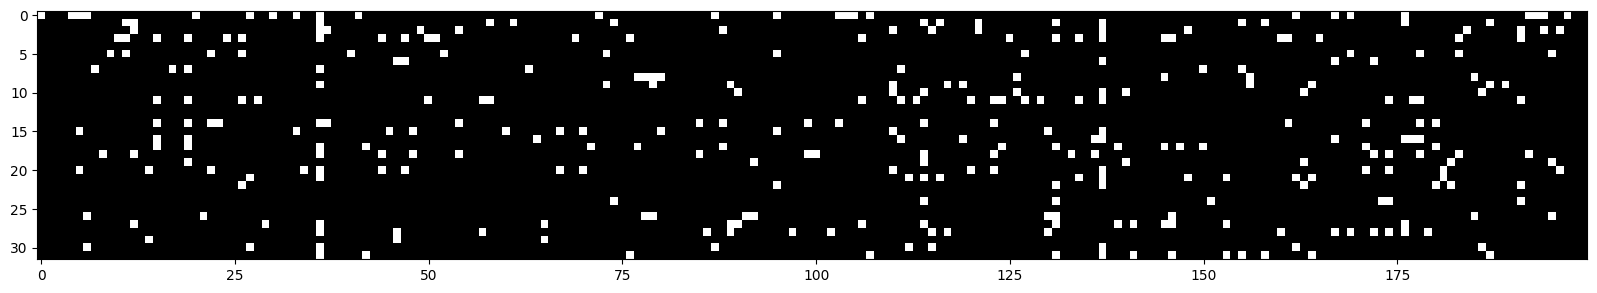

In [12]:
#Plotting of the tanh layer and seeing how many were at the extreems of -1 and 1
#A mostly black figure with some white dots indicates a healthy distribution
#A white column indicates a braindead neuron that is incapable of learning
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

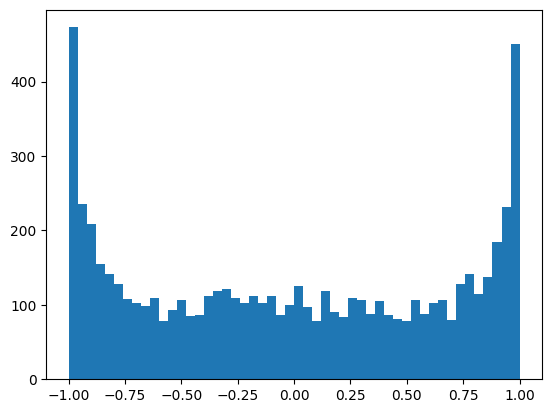

In [13]:
plt.hist(h.view(-1).tolist(), 50);

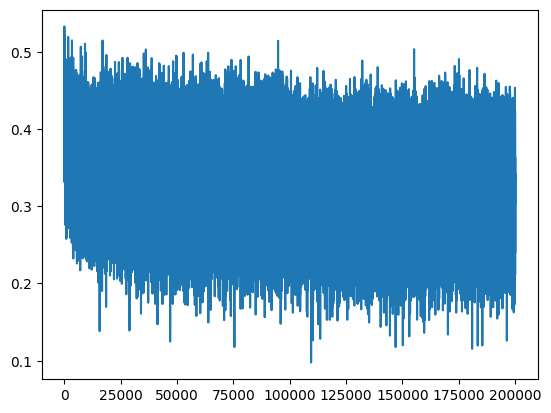

In [14]:
plt.plot(lossi)

In [41]:
#calibrate the batch normalisation at the end of training
#by finding the mean and std.dev over the entire training set
#therefore eliminating the need for training using batches
#The mean and std.dev are also locked at specific values doing this i.e. no updating
#This is optional if the mean and std.dev of the training set are going to be estimated during
#batch training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean and std.dev over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1
    #Depreacted code: hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias 
    #New way of normalising the preactivation layer without batches
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias 
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 #(N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.298912763595581
val 3.2522754669189453


In [11]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size #initialise with all ellipsis
    while True:
        #forward pass
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 )#+ b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.', token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) #decode and print the generated word

mrravgmyazhreelmnd.
fyllorethrnghjdrammraxleyd.
mlingellorenledgigvangxarvellzimrlkerin.
shubrrghhiriel.
kjadr.
julizxnthulmoubrbycdar.
jadul.
mhs.
kmajmusthyla.
hyl.
sadylisuf.
zakhlvon.
mmyn.
brisvevongenghdir.
brxondengbprillsh.
geyma.
hmrerlling.
jam.
gvondwella.
lltzellz.


In [23]:
#Repeated but torchified i.e. resembles the existing pytorch library

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d: #See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html and https://www.youtube.com/watch?v=4gal2zIjm3M

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backpropagation, affine is set to True here)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_Var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10 #the dimensionality of the character-embedding vectors
n_hidden = 100 #the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),    generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #last layer: make less confident
    #layers[-1].weight *= 0.1 <-- does not use batchnorm
    layers[-1].gamma *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of parameters total
for p in parameters:
    p.requires_grad = True

47551


In [24]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] #update:data ratio

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into the embed vectors
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()  #AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None #Removes current grad so that it doesn't get added onto the grad that's calculated in the next line
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 #step rate learning decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print (f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if i > 1000:
        break

      0/ 200000: 3.2870
